# LungCancer dataset

Dataset link : https://www.kaggle.com/datasets/antonixx/the-iqothnccd-lung-cancer-dataset

## Import packages

In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import glob
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import cv2
import random

## Reading images

In [2]:
malignant = []
normal = []
benign = []

for f in glob.iglob('./data/Malignant/*.jpg'):
    img = cv2.imread(f)
    img = cv2.resize(img, (512,512))
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])
    malignant.append(img)

for f in glob.iglob('./data/Normal/*.jpg'):
    img = cv2.imread(f)
    img = cv2.resize(img, (512,512))
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])
    normal.append(img)

for f in glob.iglob('./data/Benign/*.jpg'):
    img = cv2.imread(f)
    img = cv2.resize(img, (512,512))
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])
    benign.append(img)

In [3]:
malignant =np.array(malignant)
normal = np.array(normal)
benign = np.array(benign)
All = np.concatenate((malignant, normal, benign))

In [4]:
All.shape

(1097, 512, 512, 3)

## Visualizing MRI images

In [5]:
def plot_random(malignant, normal, benign, num=5):
    malignant_images = malignant[np.random.choice(malignant.shape[0], num, replace=False)]
    healthy_images = normal[np.random.choice(normal.shape[0], num, replace=False)]
    benign_cases = benign[np.random.choice(benign.shape[0], num, replace=False)]
    
    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('Healthy')
        plt.imshow(healthy_images[i])

    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('Malignant')
        plt.imshow(malignant_images[i])

    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('Benign Case')
        plt.imshow(benign_cases[i])

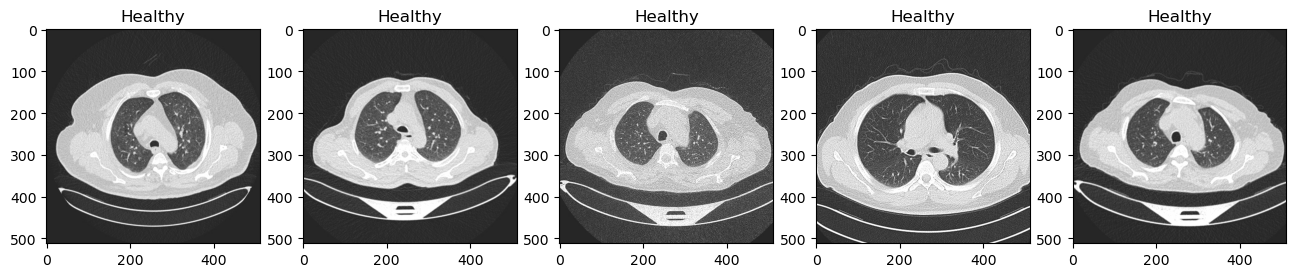

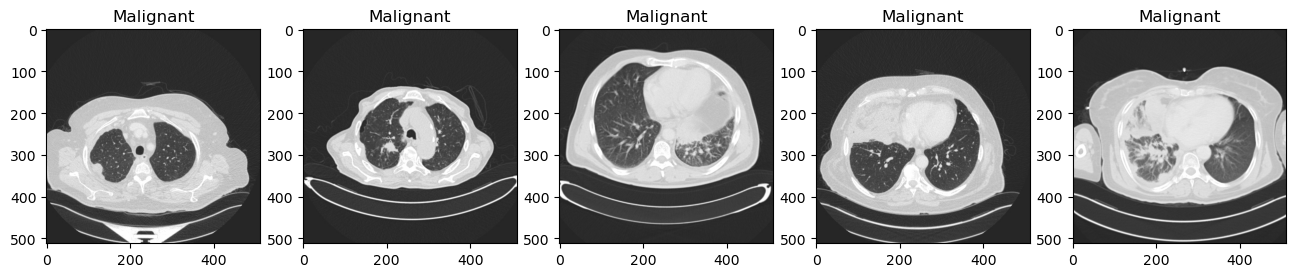

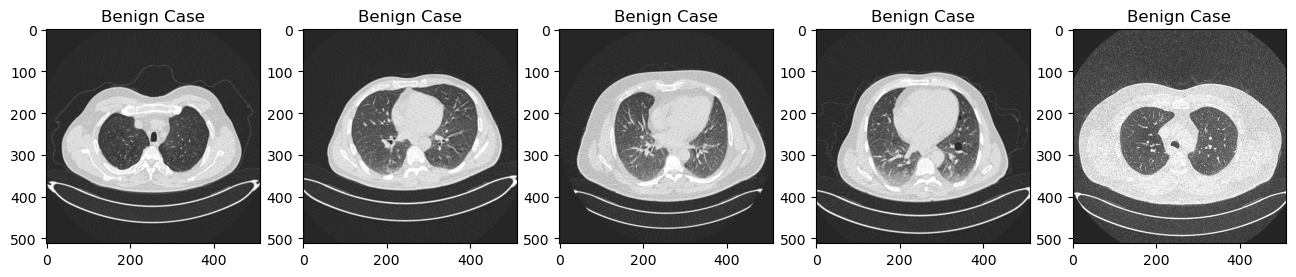

In [6]:
plot_random(malignant ,normal ,benign)

## Create torch dataset class

In [7]:
class Dataset(object):
    
    def __getitem__(self, index):
        raise NotImplementedError
        
    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])

## Create MRI custom dataset class

In [8]:
class MRI(Dataset):
    def __init__(self):
        malignant = []
        normal = []
        benign = []
        
        for f in glob.iglob('./data/Malignant/*.jpg'):
            img = cv2.imread(f)
            img = cv2.resize(img, (512,512))
            b, g, r = cv2.split(img)
            img = cv2.merge([r, g, b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            malignant.append(img)
        
        for f in glob.iglob('./data/Normal/*.jpg'):
            img = cv2.imread(f)
            img = cv2.resize(img, (512,512))
            b, g, r = cv2.split(img)
            img = cv2.merge([r, g, b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            normal.append(img)
        
        for f in glob.iglob('./data/Benign/*.jpg'):
            img = cv2.imread(f)
            img = cv2.resize(img, (512,512))
            b, g, r = cv2.split(img)
            img = cv2.merge([r, g, b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            benign.append(img)

        #images
        malignant =np.array(malignant, dtype=np.float32)
        normal = np.array(normal, dtype=np.float32)
        benign = np.array(benign, dtype=np.float32)
        #labels
        normal_label = np.zeros(normal.shape[0], dtype=np.float32)
        malignant_label = np.ones(malignant.shape[0], dtype=np.float32)
        benign_label = np.full(benign.shape[0], 2, dtype=np.float32)
        #concatination
        self.images = np.concatenate((malignant, normal, benign), axis=0)
        self.labels = np.concatenate((malignant_label, normal_label, benign_label))
        
    def __len__(self):
        return self.images.shape[0]
    
        
    def __getitem__(self, index):
        sample = {'image' : self.images[index], 'label' : self.labels[index]}
        return sample
    
    def normalize(self):
        self.images = self.images/255.0

In [9]:
mri = MRI()

In [10]:
mri.normalize()

## Build a DataLoader

In [11]:
dataloader = DataLoader(mri, batch_size=10, shuffle=True)

In [12]:
for sample in dataloader:
    img = sample['image'].squeeze()
    print(img.shape)
    sys.exit()
    


torch.Size([10, 3, 512, 512])


SystemExit: 

C:\Users\latra\anaconda3\envs\lungcancer\Lib\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Building the model

In [13]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2), 
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        self.fc_model = nn.Sequential(
            nn.Linear(in_features=16 * 128 * 128, out_features=120), 
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=3)
        )

    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc_model(x)
        return x


In [14]:
model = CNN()

In [15]:
model

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=262144, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=3, bias=True)
  )
)

In [16]:
model.cnn_model[0]

Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))

In [17]:
model.cnn_model[0].weight.shape

torch.Size([6, 3, 5, 5])

In [18]:
model.fc_model[0].weight.shape

torch.Size([120, 262144])

## Trainig the model

In [19]:
mri_dataset = MRI()
mri_dataset.normalize()
device = torch.device('cpu')
model = CNN().to(device)

In [20]:
dlr = 0.001
epoch = 100
optimizer = torch.optim.Adam(model.parameters(), lr=dlr)
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
model.train()

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=262144, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=3, bias=True)
  )
)

In [43]:
for EPOCH in range(1, epoch):
    losses = []
    for D in dataloader:
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device).long()  # Ensure labels are long type

        y_hat = model(data)

        criterion = nn.CrossEntropyLoss()
        loss = criterion(y_hat, label)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        losses.append(loss.item())

    # Print average loss every 10 epochs
    if (EPOCH + 1) % 10 == 0:
        print(f'Train Epoch: {EPOCH + 1}\tLoss: {np.mean(losses)}')

Train Epoch: 10	Loss: 0.02644311151733356
Train Epoch: 20	Loss: 0.01003707532592151
Train Epoch: 30	Loss: 0.011947659377100146
Train Epoch: 40	Loss: 0.00620272049153365
Train Epoch: 50	Loss: 0.003119008612260846
Train Epoch: 60	Loss: 0.49044943070740765
Train Epoch: 70	Loss: 0.004711399935675433
Train Epoch: 80	Loss: 0.0042377465636937875
Train Epoch: 90	Loss: 0.003783749709314829
Train Epoch: 100	Loss: 0.0018656594004677833


## Evaluation

In [51]:
model.eval()
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)
outputs = []
y_true = []
with torch.no_grad():
    for D in dataloader:
        image = D['image'].to(device)
        label = D['label'].to(device)
        
        y_hat = model(image)
        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())

outputs = np.concatenate(outputs, axis=0)
y_true = np.concatenate(y_true, axis=0)

def apply_softmax(scores):
    x = np.array(scores)
    exp_scores = np.exp(x - np.max(x, axis=1, keepdims=True))
    softmax_scores = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return softmax_scores

def threshold(scores, threshold=0.50):
    softmax_scores = apply_softmax(scores)
    predictions = np.argmax(softmax_scores, axis=1)
    return predictions

accuracy = accuracy_score(y_true, threshold(outputs))
print(f"Accuracy: {accuracy}")

Accuracy: 0.9972652689152234


[Text(0, 0.5, 'normal'), Text(0, 1.5, 'malignant'), Text(0, 2.5, 'benign')]

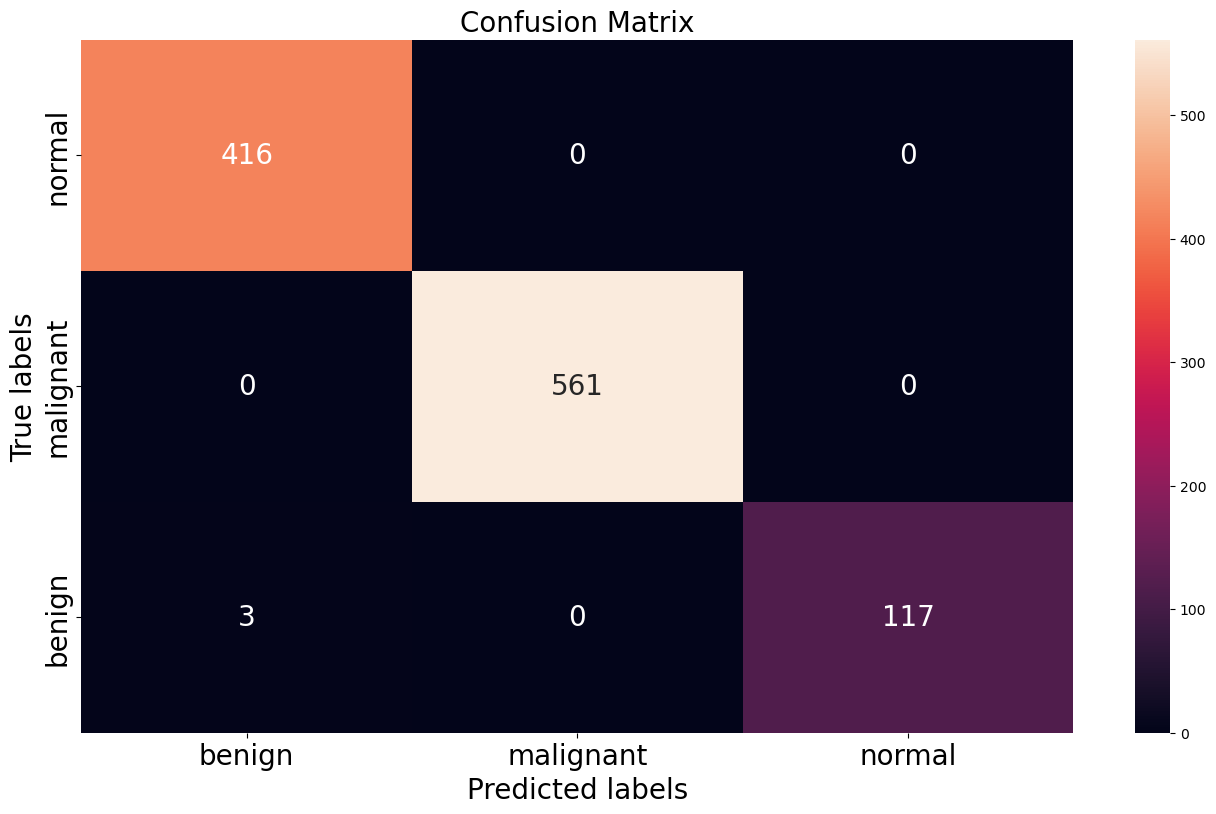

In [47]:
plt.figure(figsize=(16,9))
cm = confusion_matrix(y_true, threshold(outputs))
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={"size": 20})

ax.set_xlabel('Predicted labels', fontsize=20)
ax.set_ylabel('True labels', fontsize=20)
ax.set_title('Confusion Matrix', fontsize=20)
ax.xaxis.set_ticklabels(['benign','malignant','normal'], fontsize=20)
ax.yaxis.set_ticklabels(['normal','malignant','benign'], fontsize=20)

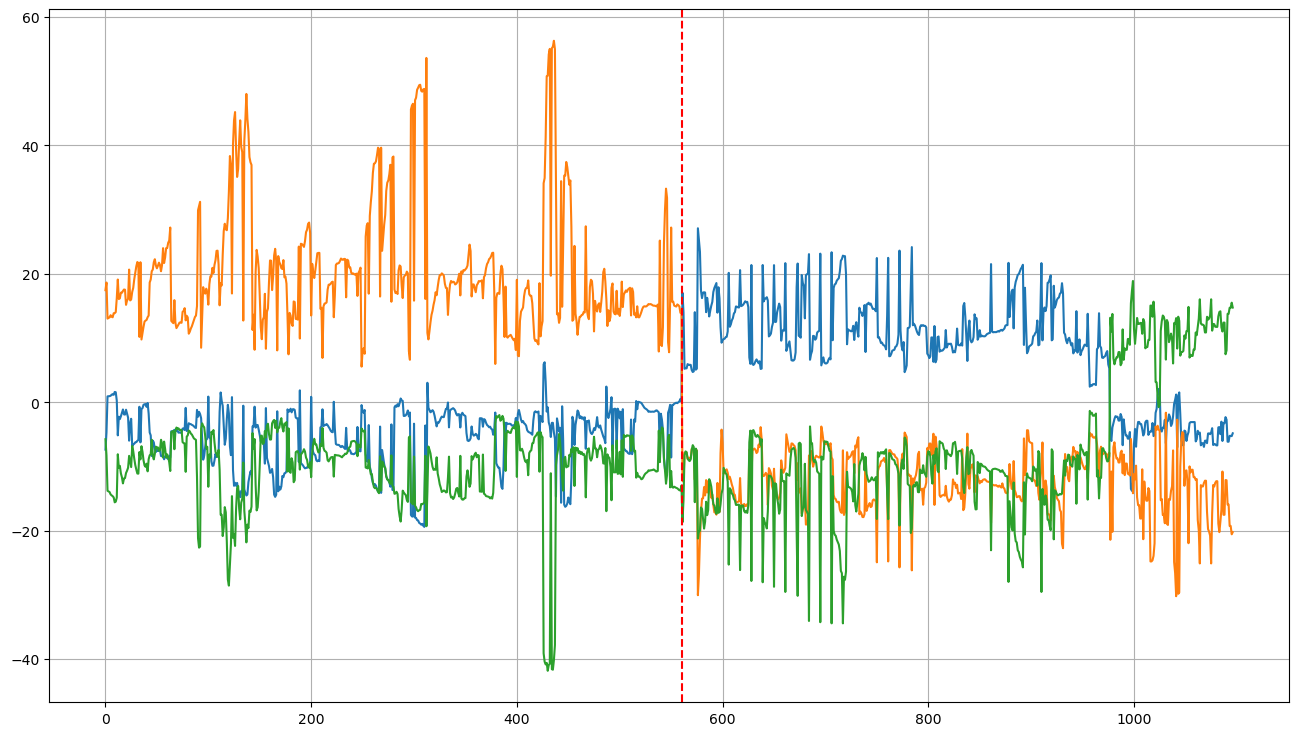

In [48]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(malignant), color='r', linestyle='--')
plt.grid()